# Homework assignment: Individual Coding Assignment

Hello! Today I'm playing around with some of the data I'm thinking of using for the final project to get a better idea of what's available. I'm experimenting with downloading and mapping the NextGen LA Metro Bus network, the existing bus network, and attempting to compare the two. 

I'm honestly not sure which of these I'll use, so I'll import a bunch of libraries that we have used in labs

In [2]:
# libraries
import urllib.request, json 
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox

## Mapping the two networks

First, I'm going to experiment with the bus networks. Okay, I downloaded the NextGen weekday bus network information and the weekday existing bus route information from this [website](https://www.metro.net/projects/nextgen/nextgen-data-and-analysis/). And I'll save both of those data sets as variables `NextGen` and `ExRoute`.

In [3]:
NextGen = gpd.read_file('data/200820_NextGen_Transit_First_DX15.shp')
ExRoute = gpd.read_file('data/Existing_Bus_System.shp')

Let's get some more information about what these different datasets look like. I'll do `.info()` and `.head()` for both to get an idea of what I'm working with, starting with `NextGen`

In [4]:
NextGen.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 284 entries, 0 to 283
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Id          284 non-null    int64   
 1   shape_id    284 non-null    object  
 2   route_id    284 non-null    object  
 3   agency_id   0 non-null      object  
 4   rt_shrt_nm  284 non-null    object  
 5   rt_long_nm  280 non-null    object  
 6   route_desc  0 non-null      object  
 7   route_type  284 non-null    int64   
 8   rt_typ_txt  284 non-null    object  
 9   route_url   0 non-null      object  
 10  rt_color    284 non-null    object  
 11  rt_col_fmt  284 non-null    object  
 12  rt_txt_col  0 non-null      object  
 13  rt_txt_fmt  0 non-null      object  
 14  geometry    284 non-null    geometry
dtypes: geometry(1), int64(2), object(12)
memory usage: 33.4+ KB


In [5]:
NextGen.head()

,Id,shape_id,route_id,agency_id,rt_shrt_nm,rt_long_nm,route_desc,route_type,rt_typ_txt,route_url,rt_color,rt_col_fmt,rt_txt_col,rt_txt_fmt,geometry
0,0,100522,10-14179,None,10,W HOLLYWOOD-DTWN LA -AVALON STA VIA MELROSE-AV...,None,3,Bus,None,FF8000,"(255, 128, 0)",None,None,"LINESTRING (-118.26519 33.92774, -118.26519 33..."
1,0,100523,10-14179,None,10,W HOLLYWOOD-DTWN LA -AVALON STA VIA MELROSE-AV...,None,3,Bus,None,FF8000,"(255, 128, 0)",None,None,"LINESTRING (-118.38162 34.08492, -118.38375 34..."
2,0,1020099,102-14179,None,102,LEIMERT PARK - MAYWOOD VIA DISTRICT BL,None,3,Bus,None,FF8000,"(255, 128, 0)",None,None,"LINESTRING (-118.39738 33.95987, -118.39649 33..."
3,0,1020100,102-14179,None,102,LEIMERT PARK - MAYWOOD VIA DISTRICT BL,None,3,Bus,None,FF8000,"(255, 128, 0)",None,None,"LINESTRING (-118.18086 33.98625, -118.18094 33..."
4,0,1050243,105-14179,None,105,W HOLLYWOOD - VERNON VIA LA CIENEGA BL,None,3,Bus,None,FF8000,"(255, 128, 0)",None,None,"LINESTRING (-118.22746 34.00463, -118.22755 34..."


It looks like there are some columns that aren't in use. And we've got 284 rows so 284 bus routes. 'Geometry' is the mapping data. Route type 3 is for weekday schedules and so all of these should be route_type 3. On the website, it said that the dataset would include frequency as well. I'm not sure if there just is no frequency data here or if it's coded in one of these columns in a way that I don't understand. I can't figure out how to find an explanation for each column anywhere on the site.

Now I'll do the same thing with the existing bus network. Hopefully the two datasets are easy to compare.

In [6]:
ExRoute.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   rte         158 non-null    float64 
 1   rte2        158 non-null    object  
 2   rteDesc     158 non-null    object  
 3   rteNum      158 non-null    object  
 4   tier        158 non-null    object  
 5   ampk_1      158 non-null    float64 
 6   midday_1    158 non-null    float64 
 7   pmpk_1      158 non-null    float64 
 8   seven_9_10  158 non-null    float64 
 9   ten_12_13   158 non-null    float64 
 10  owl_1       158 non-null    float64 
 11  sa68        158 non-null    float64 
 12  sa111       158 non-null    float64 
 13  sa35        158 non-null    float64 
 14  sa79        158 non-null    float64 
 15  sa1012      158 non-null    float64 
 16  sa24        158 non-null    float64 
 17  su68        158 non-null    float64 
 18  su111       158 non-null    float64 
 19  

In [7]:
ExRoute.head(10)

,rte,rte2,rteDesc,rteNum,tier,ampk_1,midday_1,pmpk_1,seven_9_10,ten_12_13,...,sa79,sa1012,sa24,su68,su111,su35,su79,su1012,su24,geometry
0,2.0,2,Sunset Blvd,2,Local,15.0,15.0,15.0,20.0,30.0,...,20.0,30.0,60.0,20.0,20.0,20.0,30.0,30.0,60.0,"MULTILINESTRING ((-13165102.619 4033296.175, -..."
1,4.0,4,Santa Monica Blvd,4,Local,10.0,15.0,10.0,20.0,20.0,...,20.0,20.0,30.0,20.0,15.0,15.0,25.0,25.0,25.0,"MULTILINESTRING ((-13190607.696 4031215.079, -..."
2,10.0,10,Melrose/San Pedro,10/48,Local,7.5,20.0,10.0,30.0,60.0,...,18.0,60.0,60.0,30.0,20.0,20.0,40.0,60.0,60.0,"MULTILINESTRING ((-13165702.631 4019568.409, -..."
3,14.0,14,Beverly/Adams,14/37,Local,6.0,15.0,7.5,15.0,60.0,...,30.0,60.0,60.0,25.0,20.0,20.0,25.0,60.0,60.0,"MULTILINESTRING ((-13166009.094 4032358.063, -..."
4,16.0,16,3rd St,16,Local,10.0,10.0,20.0,15.0,30.0,...,10.0,20.0,0.0,12.0,8.0,8.0,20.0,20.0,0.0,"MULTILINESTRING ((-13178905.457 4032744.770, -..."
5,18.0,18,6th St,18,Local,5.0,10.0,7.5,22.0,30.0,...,25.0,30.0,60.0,15.0,15.0,12.0,25.0,30.0,60.0,"MULTILINESTRING ((-13149677.746 4029474.364, -..."
6,20.0,20,Wilshire Blvd,20,Local,10.0,12.0,10.0,20.0,30.0,...,25.0,30.0,30.0,25.0,20.0,20.0,20.0,30.0,30.0,"MULTILINESTRING ((-13190715.230 4031111.934, -..."
7,28.0,28,Eagle Rock/Olympic,28,Local,12.0,30.0,15.0,30.0,30.0,...,20.0,30.0,60.0,18.0,15.0,15.0,25.0,30.0,60.0,"MULTILINESTRING ((-13164469.434 4034391.139, -..."
8,30.0,30,Pico Blvd,30,Local,12.0,12.0,12.0,10.0,30.0,...,20.0,30.0,60.0,15.0,12.0,10.0,25.0,30.0,60.0,"MULTILINESTRING ((-13157114.110 4033263.399, -..."
9,33.0,33,Venice Blvd,33,Local,12.0,20.0,12.0,20.0,30.0,...,15.0,25.0,30.0,30.0,20.0,20.0,20.0,25.0,30.0,"MULTILINESTRING ((-13188099.000 4027104.775, -..."


Interesting. The NextGen route appears to have more rows, which is interesting because it's supposed to be a more paired down system. I think this has frequency, with "ampk_1", "midday_1", "pmpk_1" as the number of minutes between buses in the morning, midday, and evening. It's too bad that `NextGen` doesn't have that information. 

Next, I'll try to map both of them using `.plot()`

Here is the most basic map for the existing bus routes:

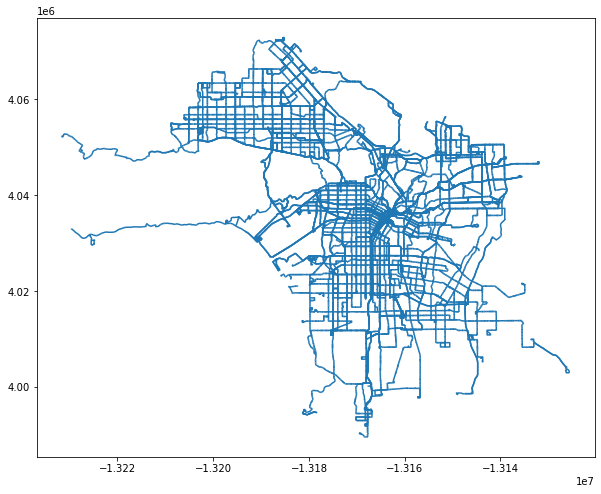

In [8]:
ExRoute.plot(figsize=(10,10))

Okay, now I'll attempt to plot a choropleth map based on the 'midday_1' frequency. 

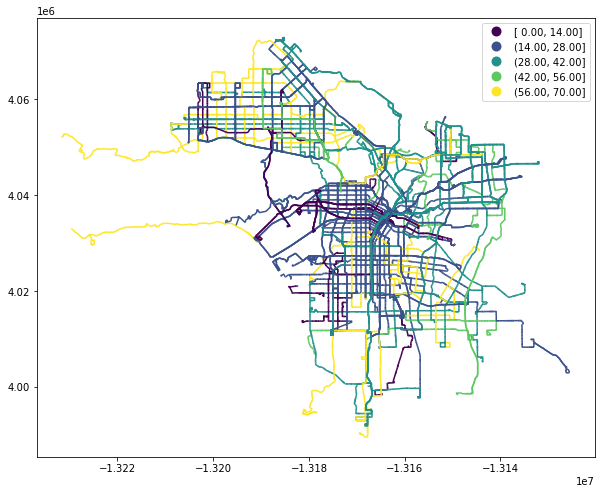

In [9]:
ExRoute.plot(figsize=(10,10),
                 column='midday_1',
                 legend=True, 
                 scheme='equal_interval')

Wow! While that's pretty exciting, I am seeing that "0.0" is included sometimes in the data, and I would assume that that mean's that the bus does not travel at all in the middle of the day, as opposed to a bus coming every second. :joy: (this will hopefully be read as a crying laughing emoji in GitHub, but it appears not Jupyter)

I'm going to try create a new variable `ExRoute_mid` that drops when 'midday_1' is equal to 0.

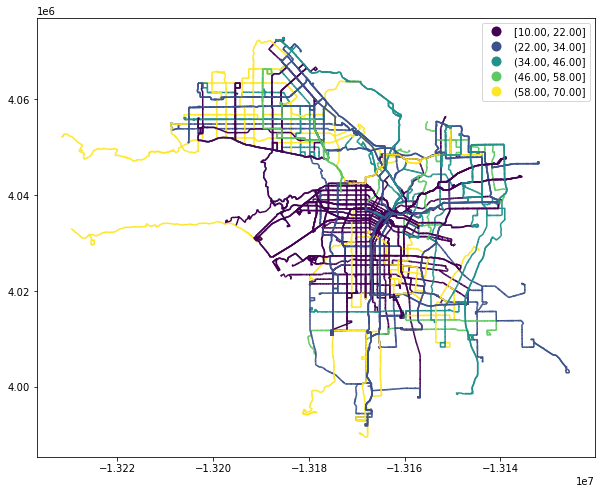

In [10]:
ExRoute_mid = ExRoute[ExRoute['midday_1']!=0]
ExRoute_mid.plot(figsize=(10,10),
                 column='midday_1',
                 legend=True, 
                 scheme='equal_interval')

Now I'll attempt to compare the am frequencies with the pm frequencies. First, I'll drop the 0's from both of these columns. 

In [11]:
ExRoute_am = ExRoute[ExRoute['ampk_1']!=0]
ExRoute_pm = ExRoute[ExRoute['pmpk_1']!=0]

Now, I'll plot both maps side by side.

Text(0.5, 1.0, 'Peak Evening Bus Frequency')

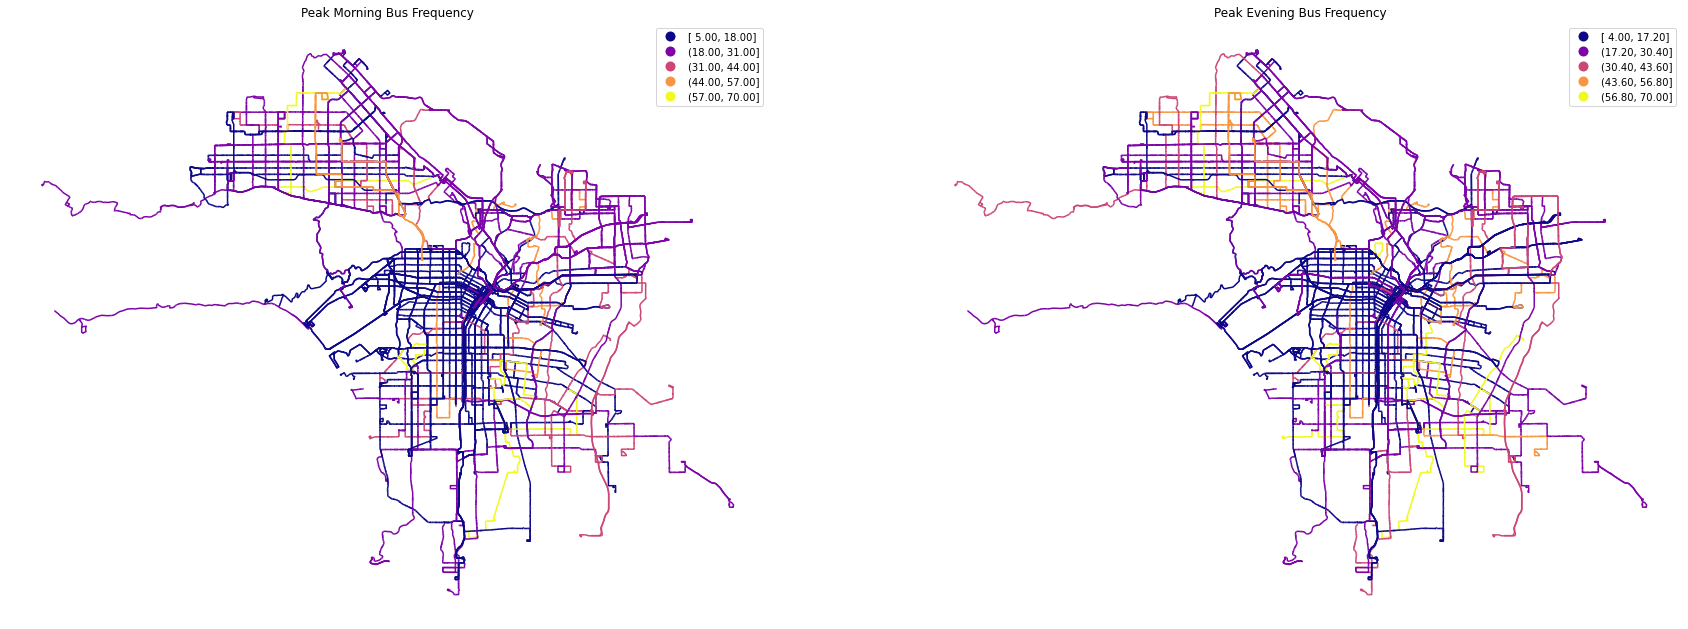

In [13]:
# create the 1x2 subplots
fig, axs = plt.subplots(1, 2, figsize=(30, 30))

# name each subplot
ax1, ax2 = axs

# regular count map on the left
ExRoute_am.plot(column='ampk_1', 
            cmap='plasma', 
            scheme='equal_interval',
            k=5, 
            ax=ax1, # this assigns the map to the subplot,
            legend=True
           )

ax1.axis("off")
ax1.set_title("Peak Morning Bus Frequency")

# spatial lag map on the right
ExRoute_pm.plot(column='pmpk_1', 
            cmap='plasma', 
            scheme='equal_interval',
            k=5,  
            ax=ax2, # this assigns the map to the subplot
            legend=True
           )

ax2.axis("off")
ax2.set_title("Peak Evening Bus Frequency")

Nice!! Well, they're a little small for comparing, but if I go much bigger, my Kernel is not happy. It's occuring to me that I don't know any directional information about these frequencies. I would guess that the buses come more often going one direction in the morning (like heading downtown) and then more often the other in the evening. I'm not sure the best way to go about getting this kind of info about the data from Metro!

Well, the NextGen data isn't as fun because I don't have frequencies. But maybe I can just compare the two plots next to each other, to get an idea of how the network has changed. 

First, I'll just plot NextGen.

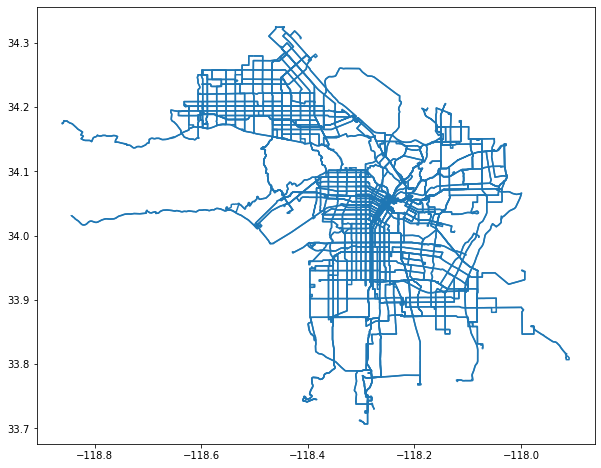

In [12]:
NextGen.plot(figsize=(10,10))

Well, scrolling up to the Existing Network, I can already see this is less extensive. 

Text(0.5, 1.0, 'NextGen Bus Network')

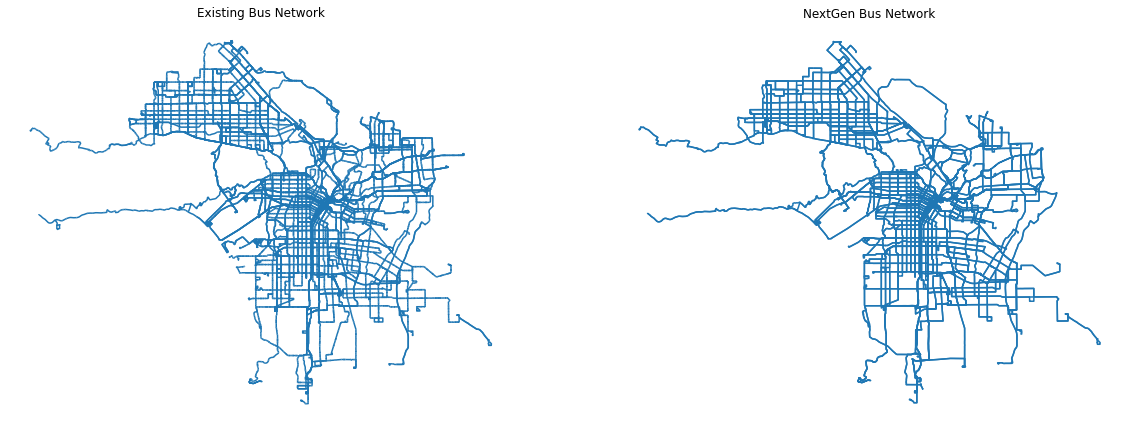

In [16]:
# create the 1x2 subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 20))

# name each subplot
ax1, ax2 = axs

# regular count map on the left
ExRoute.plot(ax=ax1, # this assigns the map to the subplot,
            legend=True
           )

ax1.axis("off")
ax1.set_title("Existing Bus Network")

# spatial lag map on the right
NextGen.plot(ax=ax2, # this assigns the map to the subplot,
            legend=True
           )

ax2.axis("off")
ax2.set_title("NextGen Bus Network")

You can kind of tell that NextGen is a little more pared down, although it's a bit subtle. I wish there was a way for me subtract the NextGen routes from the Existing Network so that I could see what didn't make the cut. However, when I look at the data, they don't have enough in common for me to compare them. It looks like the naming system changed. 

Even the numbers in the geometry column are different. When I try to plot them over each other, you can see that one of them does not appear to be in lat/lon. (You can see this in the individual maps, the NextGen axes are different numbers)

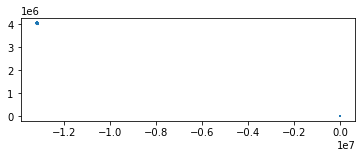

In [18]:
ax = NextGen.plot()
ExRoute.plot(ax=ax)

Maybe at some point I'll see if I can convert the NextGen data to be in latitude and longitude. 